<a href="https://colab.research.google.com/github/Koruvika/Koruvika.github.io/blob/master/MLP_For_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

In [ ]:
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Load Data

In [ ]:
(X_train_full, y_train_full) , (X_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


In [ ]:
X_train_full.shape

(50000, 32, 32, 3)

In [ ]:
y_label = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

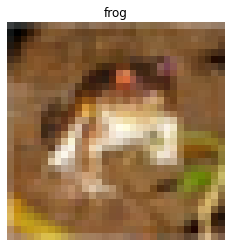

In [ ]:
plt.imshow(X_train_full[0])
plt.axis('off')
plt.title(y_label[y_train_full[0][0]])

plt.show()

In [ ]:
X_train = X_train_full[5000:].astype(np.float32)
y_train = y_train_full[5000:].reshape(-1,)

X_valid = X_train_full[:5000].astype(np.float32)
y_valid = y_train_full[:5000].reshape(-1,)

X_test = X_test.astype(np.float32)
y_test = y_test.reshape(-1,)

## Demo: Classify Images with MLP

In [ ]:
basic_mlp = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='gelu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='gelu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='gelu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='gelu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
n_epochs = 100
batch_size = 512
learning_rate = 1e-3

basic_mlp.compile(optimizer=keras.optimizers.Nadam(learning_rate=learning_rate), 
                  metrics=['accuracy'], 
                  loss='sparse_categorical_crossentropy')

history_1 = basic_mlp.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=[X_valid, y_valid])

Epoch 1/20
88/88 [==============================] - 8s 52ms/step - loss: 2.0234 - accuracy: 0.2805 - val_loss: 1.9285 - val_accuracy: 0.3138
Epoch 2/20
88/88 [==============================] - 4s 48ms/step - loss: 1.7435 - accuracy: 0.3743 - val_loss: 1.5808 - val_accuracy: 0.4328
Epoch 3/20
88/88 [==============================] - 4s 49ms/step - loss: 1.6405 - accuracy: 0.4121 - val_loss: 1.4945 - val_accuracy: 0.4668
Epoch 4/20
88/88 [==============================] - 4s 48ms/step - loss: 1.5796 - accuracy: 0.4337 - val_loss: 1.4538 - val_accuracy: 0.4774
Epoch 5/20
88/88 [==============================] - 4s 49ms/step - loss: 1.5340 - accuracy: 0.4509 - val_loss: 1.4370 - val_accuracy: 0.4818
Epoch 6/20
88/88 [==============================] - 4s 49ms/step - loss: 1.4966 - accuracy: 0.4665 - val_loss: 1.4287 - val_accuracy: 0.4922
Epoch 7/20
88/88 [==============================] - 4s 49ms/step - loss: 1.4591 - accuracy: 0.4784 - val_loss: 1.3940 - val_accuracy: 0.4998
Epoch 8/20
88

In [ ]:
basic_mlp.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.5353 - accuracy: 0.5122


[1.5353482961654663, 0.5121999979019165]

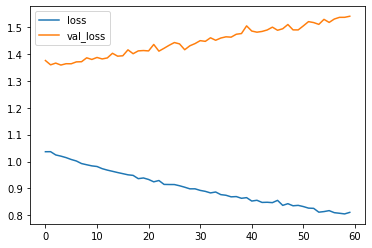

In [ ]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])

plt.legend(['loss', 'val_loss'])
plt.show()

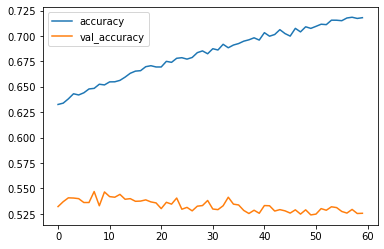

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])

plt.legend(['accuracy', 'val_accuracy'])
plt.show()

### Comment:
Model will can learning but be overfitting

Valid Accuracy ~ 53%

Test Accuracy ~ 51%

## Mixer-MLP

In [ ]:
class MLPBlock(keras.Model):
    def __init__(self, mlp_dim, **kwargs):
        super(MLPBlock, self).__init__(**kwargs)
        self.mlp_dim = mlp_dim
    def call(self, X):
        y = keras.layers.Dense(self.mlp_dim)(X)
        y = keras.activations.gelu()(y)
        return keras.layers.Dense(X.shape[-1])(y)

In [ ]:
class MixerMLP(keras.Model):
    def __init__(self, tokens_mlp_dim, channels_mlp_dim, **kwargs):
        super(MixerMLP, self).__init__(**kwargs)
        self.tokens_mlp_dim = tokens_mlp_dim
        self.channels_mlp_dim = channels_mlp_dim
    def call(self, X):
        y = keras.layers.LayerNormalization()(X)
        y = tf.linalg.matrix_transpose(y)
        y = MLPBlock(self.tokens_mlp_dim)(y)
        y = tf.linalg.matrix_transpose(y)
        X = X + y
        y = keras.layers.LayerNormalization()(X)
        y = MLPBlock(self.channels_mlp_dim)(y)
        return X + y

In [ ]:
mixer_layer = MixerMLP()